In [111]:
# Provides ways to work with large multidimensional arrays
import numpy as np 
# Allows for further data manipulation and analysis
import pandas as pd
from pandas_datareader import data # Reads stock data 
import matplotlib.pyplot as plt # Plotting
import matplotlib.dates as mdates # Styling dates
%matplotlib inline

import datetime as dt # For defining dates
# import mplfinance as mpf # Matplotlib finance

import time

# Used to get data from a directory
import os
from os import listdir
from os.path import isfile, join

#Statsmodels is a great library we can use to run regressions.
import statsmodels.api as sm
# Seaborn extends the capabilities of Matplotlib
import seaborn as sns
# Used for calculating regressions
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [113]:
#change the tickers here according to what's in the portfolio
tickers = ['LHX','ODFL','SAIA','AXP','TROW','CG','CSWC','CBRE','SBAC','EPAM','QCOM','ASML','DSGX',
          'MGIC','RDWR','CTLT','BRKR','ICLR','MODV','^FVX','SPY']

start_date = '2017-01-01'
end_date = '2022-01-01'

panel_data = data.DataReader(tickers,'yahoo', start_date, end_date)

In [114]:
#check that all stocks have the same amount of data otherwise change the date range

adj_close = panel_data['Adj Close']
adj_close.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2017-01-03 to 2021-12-31
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   LHX     1259 non-null   float64
 1   ODFL    1259 non-null   float64
 2   SAIA    1259 non-null   float64
 3   AXP     1259 non-null   float64
 4   TROW    1259 non-null   float64
 5   CG      1259 non-null   float64
 6   CSWC    1259 non-null   float64
 7   CBRE    1259 non-null   float64
 8   SBAC    1259 non-null   float64
 9   EPAM    1259 non-null   float64
 10  QCOM    1259 non-null   float64
 11  ASML    1259 non-null   float64
 12  DSGX    1259 non-null   float64
 13  MGIC    1259 non-null   float64
 14  RDWR    1259 non-null   float64
 15  CTLT    1259 non-null   float64
 16  BRKR    1259 non-null   float64
 17  ICLR    1259 non-null   float64
 18  MODV    1259 non-null   float64
 19  ^FVX    1259 non-null   float64
 20  SPY     1259 non-null   float64
dtypes: float64(21)
memo

## Function that saves dataframe to CSV

In [115]:
def save_dataframe_to_csv(kind, df, ticker):
    df.to_csv(kind + ticker + '.csv')

In [116]:
# for ticker in tickers:
#     panel_data = data.DataReader(ticker,'yahoo', start_date, end_date)
# #     close = panel_data['Close']
#     adj_close = panel_data['Adj Close']
#     save_dataframe_to_csv('adj_close', adj_close, ticker)

## Function that returns dataframe from a CSV

In [117]:
def get_df_from_csv(kind, ticker):
    try:
        df = pd.read_csv(kind + ticker + '.csv', index_col='Date', 
                         parse_dates=True)
    except FileNotFoundError:
        pass
        # print("File Doesn't Exist")
    else:
        return df

## Add Daily Return to dataframe

In [118]:
def add_daily_return_to_df(kind, df, ticker):
    df['daily_return'] = (df['Adj Close'] / df['Adj Close'].shift(1)) - 1
    # Save data to a CSV file
    save_dataframe_to_csv(kind, df, ticker)
    return df

In [119]:
for ticker in tickers:
    df = get_df_from_csv('adj_close', ticker)
    add_daily_return_to_df('adj_close', df, ticker)

## Merge multiple stocks in one dataframe by col name

In [144]:
def merge_df_by_column_name(col_name, sdate, edate, *tickers):
    # Will hold data for all dataframes with the same column name
    mult_df = pd.DataFrame()
    
    for x in tickers:
        df = get_df_from_csv('adj_close', x)
        
        # NEW Check if your dataframe has duplicate indexes
        if not df.index.is_unique:
            # Delete duplicates 
            df = df.loc[~df.index.duplicated(), :]
        
        mask = (df.index >= sdate) & (df.index <= edate)
        mult_df[x] = df.loc[mask][col_name]
        
    return mult_df

## Get stock prices on date

In [145]:
def get_prices_on_date(stocks_df, date):
    return stocks_df.loc[pd.DatetimeIndex([date])]['Adj Close'].item()

## Returns the value of portfolio by date

In [146]:
def get_port_val_by_date(date, shares, tickers):
    port_prices = merge_df_by_column_name('Adj Close',  date, date, *port_list)
    # Convert from dataframe to Python list
    port_prices = port_prices.values.tolist()
    # Trick that converts a list of lists into a single list
    port_prices = sum(port_prices, [])
    
    # Create a list of values by multiplying shares by price
    value_list = []
    for price, share in zip(port_prices, shares):
        value_list.append(price * share)
    
    return sum(value_list)

## Get value of portfolio at beginning and end of year

In [147]:
# port_shares = [0.0145161,0.068463,0.0070209,0.00164655,0.01234755,0.0179883,0.0130176,0.033096,
#                0.071904,0.0091785,2.43E-05,0.0103785,0.0060897,0.0027567,0.0015723,0.0087756,
#                0.0066555,0.0100752,0.0044937]

# new_port_list = []

# for num in port_shares:
#     new_num = num*3.33
#     new_port_list.append(new_num)
    
# port_shares = new_port_list

In [148]:
#change to the list of stocks we using
port_list = ['LHX','ODFL','SAIA','AXP','TROW','CG','CSWC','CBRE','SBAC','EPAM','QCOM','ASML','DSGX',
          'MGIC','RDWR','CTLT','BRKR','ICLR','MODV']

#add in the weightage of stocks
port_shares = [0.0145161,0.068463,0.0070209,0.00164655,0.01234755,0.0179883,0.0130176,0.033096,
               0.071904,0.0091785,2.43E-05,0.0103785,0.0060897,0.0027567,0.0015723,0.0087756,
               0.0066555,0.0100752,0.0044937]

# Portfolio value at start of 2021
port_val_start = get_port_val_by_date('2021-01-04', port_shares, port_list)
print("Portfolio Value at Start of 2021 : $%2.2f" % (port_val_start))

# Portfolio value at end of 2021
port_val_end = get_port_val_by_date('2021-12-31', port_shares, port_list)
print("Portfolio Value at End of 2021 : $%2.2f" % (port_val_end))

Portfolio Value at Start of 2021 : $53.74
Portfolio Value at End of 2021 : $85.94


## Calculate ROI

In [149]:
# Rate of return for portfolio
roi_port = (port_val_end - port_val_start) / port_val_end
print("Portfolio ROI at End of 2021 : %2.2f %%" % (roi_port * 100))

# S&P ROI
sp_df = get_df_from_csv('adj_close','SPY')
sp_val_start = get_prices_on_date(sp_df, '2021-01-04')
sp_val_end = get_prices_on_date(sp_df, '2021-12-31')
sp_roi = (sp_val_end - sp_val_start) / sp_val_end
print("S&P ROI at End of 2021 : %2.2f %%" % (sp_roi * 100))

Portfolio ROI at End of 2021 : 37.46 %
S&P ROI at End of 2021 : 23.37 %


## Find Daily Return for Whole Portfolio

In [150]:
def get_port_daily_return(sdate, edate, shares, tickers):
    # Merge all daily prices for all stocks into 1 dataframe
    mult_df = merge_df_by_column_name('Adj Close',  sdate, 
                                  edate, *port_list)
    
    # Get the number of stocks in portfolio
    num_cols = len(mult_df.columns)
    
    # Multiply each stock column by the number of shares
    i = 0
    while i < num_cols:
        mult_df[tickers[i]] = mult_df[tickers[i]].apply(lambda x: x * shares[i])
        i += 1
        
    # Create a new column with the sums of all stocks named Total
    mult_df['Total'] = mult_df.iloc[:, 0:num_cols].sum(axis=1)
    
    # Add column for portfolio daily return
    mult_df['daily_return'] = (mult_df['Total'] / mult_df['Total'].shift(1)) - 1
    
    return mult_df

In [151]:
#change to the list of stocks we using
port_list = ['LHX','ODFL','SAIA','AXP','TROW','CG','CSWC','CBRE','SBAC','EPAM','QCOM','ASML','DSGX',
          'MGIC','RDWR','CTLT','BRKR','ICLR','MODV']

#add in the weightage of stocks
port_shares = [0.0145161,0.068463,0.0070209,0.00164655,0.01234755,0.0179883,0.0130176,0.033096,
               0.071904,0.0091785,2.43E-05,0.0103785,0.0060897,0.0027567,0.0015723,0.0087756,
               0.0066555,0.0100752,0.0044937]

# tot_port_df = get_port_daily_return('2020-01-02', '2020-12-31', 
#                                     port_shares, port_list)

#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2022-01-01', port_shares, port_list)
tot_port_df

,LHX,ODFL,SAIA,AXP,TROW,CG,CSWC,CBRE,SBAC,EPAM,...,ASML,DSGX,MGIC,RDWR,CTLT,BRKR,ICLR,MODV,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,1.361083,3.881017,0.315238,0.114898,0.799618,0.219965,0.166078,1.044841,7.444282,0.584303,...,1.091921,0.129406,0.016184,0.023081,0.236941,0.140677,0.752718,0.172423,18.496014,NaN
2017-01-04,1.368504,3.897117,0.316292,0.116782,0.811532,0.226310,0.170144,1.061720,7.454864,0.590728,...,1.086681,0.130624,0.016302,0.023207,0.239662,0.142111,0.773977,0.176962,18.604857,0.005885
2017-01-05,1.370226,3.851053,0.308569,0.115342,0.805206,0.229835,0.169941,1.052784,7.356104,0.594308,...,1.099730,0.128797,0.016419,0.023097,0.236064,0.142437,0.767831,0.176153,18.445237,-0.008579
2017-01-06,1.385332,3.850606,0.315098,0.115572,0.797299,0.234770,0.167705,1.032595,7.302492,0.613766,...,1.098544,0.129406,0.016302,0.023034,0.235888,0.143676,0.792414,0.177276,18.433116,-0.000657
2017-01-09,1.353398,3.829587,0.309622,0.116169,0.767882,0.235475,0.169941,1.030278,7.265106,0.613491,...,1.112088,0.129102,0.016302,0.022798,0.236151,0.145240,0.809744,0.175973,18.339691,-0.005068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,3.039789,24.322185,2.338311,0.269999,2.439451,1.004694,0.319966,3.567418,27.504880,6.397414,...,8.421426,0.498259,0.058334,0.064181,1.108885,0.550422,3.099333,0.678998,85.688454,0.021676
2021-12-28,3.066237,24.393318,2.318231,0.270032,2.440552,0.992527,0.319201,3.565101,27.603173,6.261573,...,8.352306,0.499355,0.057407,0.063568,1.100109,0.545900,3.083515,0.673965,85.610542,-0.000909
2021-12-29,3.069272,24.678536,2.354880,0.269079,2.417665,0.972845,0.317543,3.593564,27.618959,6.221555,...,8.323349,0.502035,0.057516,0.065203,1.123979,0.556807,3.103061,0.675044,85.925397,0.003678


## Find Portfolio Beta

In [152]:
def find_port_beta(port_df, sdate, edate):
    # Will hold data for S&P and my portfolio
    mult_df = pd.DataFrame()
    
    # Mask defining the dates worth of data that we want
    port_mask = (port_df.index >= sdate) & (port_df.index <= edate)
    
    # Get S&P Dataframe
    sp_df = get_df_from_csv('adj_close','SPY')
    
    sp_mask = (sp_df.index >= sdate) & (sp_df.index <= edate)
    
    # Add S&P daily return to dataframe
    mult_df['SPY'] = sp_df.loc[sp_mask]['daily_return']
    
    # Add the portfolio daily return data
    mult_df['Portfolio'] = port_df.loc[port_mask]['daily_return']
    
    # Provides the covariance between the securities
    cov = mult_df.cov() * 252
    
    # Get the covariance of the stocks and the market
    cov_vs_market = cov.iloc[0,1]
    
    # Get annualized variance of the S&P
    sp_var = mult_df['SPY'].var() * 252
    
    # Beta is normally calculated over a 5 year period which is why you may see a difference
    beta = cov_vs_market / sp_var
    return beta

## Calculating alpha

In [153]:
port_beta = find_port_beta(tot_port_df, '2021-01-04', '2021-12-31')
port_beta

1.0060488047182292

In [154]:
risk_free_rate = 0.01
port_alpha = roi_port - risk_free_rate - (port_beta * (sp_roi - risk_free_rate))
print("Portfolio Alpha : %2.2f %%" % (port_alpha * 100))

Portfolio Alpha : 13.95 %


## Get old data for portfolio

In [155]:
#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2022-01-01', 
                                    port_shares, port_list)
tot_port_df

,LHX,ODFL,SAIA,AXP,TROW,CG,CSWC,CBRE,SBAC,EPAM,...,ASML,DSGX,MGIC,RDWR,CTLT,BRKR,ICLR,MODV,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,1.361083,3.881017,0.315238,0.114898,0.799618,0.219965,0.166078,1.044841,7.444282,0.584303,...,1.091921,0.129406,0.016184,0.023081,0.236941,0.140677,0.752718,0.172423,18.496014,NaN
2017-01-04,1.368504,3.897117,0.316292,0.116782,0.811532,0.226310,0.170144,1.061720,7.454864,0.590728,...,1.086681,0.130624,0.016302,0.023207,0.239662,0.142111,0.773977,0.176962,18.604857,0.005885
2017-01-05,1.370226,3.851053,0.308569,0.115342,0.805206,0.229835,0.169941,1.052784,7.356104,0.594308,...,1.099730,0.128797,0.016419,0.023097,0.236064,0.142437,0.767831,0.176153,18.445237,-0.008579
2017-01-06,1.385332,3.850606,0.315098,0.115572,0.797299,0.234770,0.167705,1.032595,7.302492,0.613766,...,1.098544,0.129406,0.016302,0.023034,0.235888,0.143676,0.792414,0.177276,18.433116,-0.000657
2017-01-09,1.353398,3.829587,0.309622,0.116169,0.767882,0.235475,0.169941,1.030278,7.265106,0.613491,...,1.112088,0.129102,0.016302,0.022798,0.236151,0.145240,0.809744,0.175973,18.339691,-0.005068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,3.039789,24.322185,2.338311,0.269999,2.439451,1.004694,0.319966,3.567418,27.504880,6.397414,...,8.421426,0.498259,0.058334,0.064181,1.108885,0.550422,3.099333,0.678998,85.688454,0.021676
2021-12-28,3.066237,24.393318,2.318231,0.270032,2.440552,0.992527,0.319201,3.565101,27.603173,6.261573,...,8.352306,0.499355,0.057407,0.063568,1.100109,0.545900,3.083515,0.673965,85.610542,-0.000909
2021-12-29,3.069272,24.678536,2.354880,0.269079,2.417665,0.972845,0.317543,3.593564,27.618959,6.221555,...,8.323349,0.502035,0.057516,0.065203,1.123979,0.556807,3.103061,0.675044,85.925397,0.003678


## Forecasting

In [156]:
tot_port_df = tot_port_df.asfreq('d')
tot_port_df.index

DatetimeIndex(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06',
               '2017-01-07', '2017-01-08', '2017-01-09', '2017-01-10',
               '2017-01-11', '2017-01-12',
               ...
               '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', name='Date', length=1824, freq='D')

In [157]:
# Delete NaNs for nontrading days
tot_port_df = tot_port_df.fillna(method='ffill')

In [158]:
tot_port_df

,LHX,ODFL,SAIA,AXP,TROW,CG,CSWC,CBRE,SBAC,EPAM,...,ASML,DSGX,MGIC,RDWR,CTLT,BRKR,ICLR,MODV,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,1.361083,3.881017,0.315238,0.114898,0.799618,0.219965,0.166078,1.044841,7.444282,0.584303,...,1.091921,0.129406,0.016184,0.023081,0.236941,0.140677,0.752718,0.172423,18.496014,NaN
2017-01-04,1.368504,3.897117,0.316292,0.116782,0.811532,0.226310,0.170144,1.061720,7.454864,0.590728,...,1.086681,0.130624,0.016302,0.023207,0.239662,0.142111,0.773977,0.176962,18.604857,0.005885
2017-01-05,1.370226,3.851053,0.308569,0.115342,0.805206,0.229835,0.169941,1.052784,7.356104,0.594308,...,1.099730,0.128797,0.016419,0.023097,0.236064,0.142437,0.767831,0.176153,18.445237,-0.008579
2017-01-06,1.385332,3.850606,0.315098,0.115572,0.797299,0.234770,0.167705,1.032595,7.302492,0.613766,...,1.098544,0.129406,0.016302,0.023034,0.235888,0.143676,0.792414,0.177276,18.433116,-0.000657
2017-01-07,1.385332,3.850606,0.315098,0.115572,0.797299,0.234770,0.167705,1.032595,7.302492,0.613766,...,1.098544,0.129406,0.016302,0.023034,0.235888,0.143676,0.792414,0.177276,18.433116,-0.000657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,3.039789,24.322185,2.338311,0.269999,2.439451,1.004694,0.319966,3.567418,27.504880,6.397414,...,8.421426,0.498259,0.058334,0.064181,1.108885,0.550422,3.099333,0.678998,85.688454,0.021676
2021-12-28,3.066237,24.393318,2.318231,0.270032,2.440552,0.992527,0.319201,3.565101,27.603173,6.261573,...,8.352306,0.499355,0.057407,0.063568,1.100109,0.545900,3.083515,0.673965,85.610542,-0.000909
2021-12-29,3.069272,24.678536,2.354880,0.269079,2.417665,0.972845,0.317543,3.593564,27.618959,6.221555,...,8.323349,0.502035,0.057516,0.065203,1.123979,0.556807,3.103061,0.675044,85.925397,0.003678


In [159]:
# Delete all unneeded columns - basically delete all except Total
del_col = ['LHX','ODFL','SAIA','AXP','TROW','CG','CSWC','CBRE','SBAC','EPAM','QCOM','ASML','DSGX',
          'MGIC','RDWR','CTLT','BRKR','ICLR','MODV', "daily_return"]

for x in del_col:
    tot_port_df = tot_port_df.drop([x], axis=1)

In [160]:
tot_port_df

,Total
Date,
2017-01-03,18.496014
2017-01-04,18.604857
2017-01-05,18.445237
2017-01-06,18.433116
2017-01-07,18.433116
...,...
2021-12-27,85.688454
2021-12-28,85.610542
2021-12-29,85.925397


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use t

Lags : [1 2]
Observations : 1824


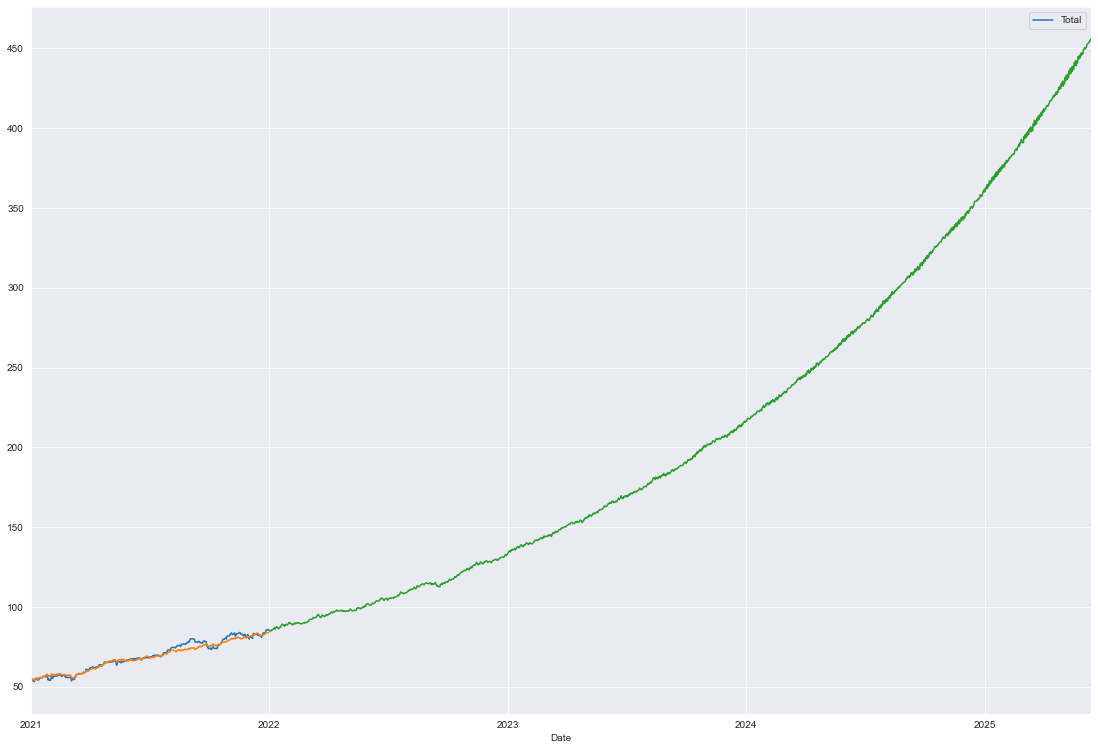

In [161]:
# Set style for seaborn plot
sns.set_style('darkgrid')
# Add automatic datetime converters
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(19, 13))

# Set fig and ax
fig, ax = plt.subplots()

# Figure out optimum lags for this data set
lags = ar_select_order(tot_port_df, maxlag=30)
print("Lags :", lags.ar_lags)

# Create our model using whole data set
model = AutoReg(tot_port_df['Total'], lags.ar_lags)
model_fit = model.fit()

# Define training and testing area
print("Observations :", len(tot_port_df)) # 1095 observations

train_df = tot_port_df.iloc[0:1459] # First 80% 
test_df = tot_port_df.iloc[1459:] # Last 20%

# Define training model for 459 days (Play with Number & Test)
# and White's covariance estimator
train_model = AutoReg(tot_port_df['Total'], 459).fit(cov_type="HC0")

# # Define start and end for prediction 
start = len(train_df)
end = len(train_df) + len(test_df) - 1

prediction = train_model.predict(start=start, end=end, dynamic=True)

# Plot testing data with prediction
ax = test_df.plot(ax=ax) # blue
ax = prediction.plot(ax=ax) # orange

# Predict 60 days into the future
forecast = train_model.predict(start=end, end=end+1260, dynamic=True)
ax = forecast.plot(ax=ax) # Green

## Calculate annualized returns for forecasted

In [162]:
forecast

2021-12-31     85.523354
2022-01-01     85.403998
2022-01-02     84.915412
2022-01-03     84.900476
2022-01-04     85.347888
                 ...    
2025-06-09    453.345938
2025-06-10    454.108680
2025-06-11    454.509934
2025-06-12    455.717419
2025-06-13    454.730580
Freq: D, Length: 1261, dtype: float64

In [163]:
forecast_df = pd.DataFrame(forecast)

In [164]:
forecast_df

,0
2021-12-31,85.523354
2022-01-01,85.403998
2022-01-02,84.915412
2022-01-03,84.900476
2022-01-04,85.347888
...,...
2025-06-09,453.345938
2025-06-10,454.108680
2025-06-11,454.509934
2025-06-12,455.717419


In [165]:
return_series = (1 + forecast_df.pct_change()).cumprod() - 1

In [166]:
return_series

,0
2021-12-31,NaN
2022-01-01,-0.001396
2022-01-02,-0.007108
2022-01-03,-0.007283
2022-01-04,-0.002052
...,...
2025-06-09,4.300844
2025-06-10,4.309762
2025-06-11,4.314454
2025-06-12,4.328573


In [167]:
#calculate annualized return
total_return = return_series.tail(1)

annualized_return = ((1 + total_return)**(1/5))-1

print(annualized_return*100)

                    0
2025-06-13  39.679891
